In [1]:
import wandb
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

api = wandb.Api()
runs = api.runs('shehper/AC-Solver-PPO')

### Performance vs Interactions

In [2]:
class Performance_vs_Interactions:
    """
    A class to obtain performance metrics (number of solved examples or mean return) as functions of total number of environment interactions 
    across various experiments.

    Attributes:
        states_type (str): Specifies the type of states to include, either "solved" or "all". This pertains to the initial state distribution of AC Environment.
        mean_returns_data (dict): Stores the mean returns data of runs. Keys are ids of runs, and values are mean returns. 
        num_solved_data (dict): Stores the number of solved instances data of runs.
        optimal_lr_data (dict): Stores the optimal learning rates data of runs. It saves optimal learning rate as a function of number of environment interactions.

    Methods:
        relevant_runs: Returns a list of runs that meet the criteria relevant for this analysis.
        _selection_criteria(run): Evaluates a run to determine if it meets all the specified conditions.
        get_num_solved_data: Computes and returns the average number of solved instances for each run configuration.
        get_mean_returns_data: Computes and returns the average normalized returns for each run configuration.
        get_data(metric): Returns the aggregated data based on the specified metric ('num_solved' or 'mean_returns').
        get_optimal_lr(metric): Computes and returns the optimal learning rate as a function of total number of environment interactions
                                for maximizing the specified metric.
        get_perf_vs_E(metric): Returns a tuple of sorted environment steps and the corresponding performance data.
    """
    def __init__(self, states_type):
        self.states_type=states_type
        self.mean_returns_data = None
        self.num_solved_data = None
        self.optimal_lr_data = None
    
    @property
    def relevant_runs(self):
        relevant_runs = [run for run in runs if self._selection_criteria(run)]
        print(f"{len(relevant_runs)} found for the task!")
        return relevant_runs
    
    def _selection_criteria(self, run):
        cfg = run.config
        state = run.state
        allowed_states = ("finished") # could also be ("finished", "running")
        if all([cfg["states_type"] == self.states_type,
                cfg["anneal_lr"] == False,
                cfg["max_env_steps"] == 200,
                cfg["num_steps"] == 200,
                cfg["nodes_counts"] == [512, 512],
                cfg["total_timesteps"] <= 8e7,
                state in allowed_states]):
            return True 
        else:
            return False
        
    def get_num_solved_data(self):
        self.num_solved_data = {}

        for run in self.relevant_runs:
            cfg = run.config
            T = cfg["total_timesteps"]
            lr = cfg["learning_rate"]
            n_solved = run.summary["charts/solved"]

            if (T, lr) not in self.num_solved_data.keys():
                self.num_solved_data[(T, lr)] = []
            self.num_solved_data[(T, lr)].append(n_solved)

        for k, v in self.num_solved_data.items():
            self.num_solved_data[k] = np.mean(v)

        return self.num_solved_data
    
    def get_mean_returns_data(self):
        self.mean_returns_data = {}

        for run in self.relevant_runs:
            cfg = run.config
            T = cfg["total_timesteps"]
            lr = cfg["learning_rate"]
            returns = run.summary["charts/normalized_returns_mean"]

            if (T, lr) not in self.mean_returns_data.keys():
                self.mean_returns_data[(T, lr)] = []
            self.mean_returns_data[(T, lr)].append(returns)

        for k, v in self.mean_returns_data.items():
            self.mean_returns_data[k] = np.mean(v)

        return self.mean_returns_data

    def get_data(self, metric="num_solved"):
        if metric == "num_solved":
            return self.get_num_solved_data()
        elif metric == "mean_returns":
            return self.get_mean_returns_data()
        else:
            raise("metric must be num_solved or mean_returns")

    def get_optimal_lr(self, metric="num_solved"):

        self.optimal_lr_data = {}

        if metric == "num_solved":
            data = self.num_solved_data
        elif metric == "mean_returns":
            data = self.mean_returns_data

        if data is None:
            data = self.get_data(metric=metric)

        for (T, lr), num_solved in data.items():
            if T not in self.optimal_lr_data.keys():
                self.optimal_lr_data[T] = (lr, num_solved)
            else:
                _, previous_best_num_solved = self.optimal_lr_data[T]
                if num_solved > previous_best_num_solved:
                    self.optimal_lr_data[T] = (lr, num_solved)

        return self.optimal_lr_data

    def get_perf_vs_E(self, metric="num_solved"):
        if self.optimal_lr_data is None:
            self.optimal_lr_data = self.get_optimal_lr(metric=metric)

        Es = list(self.optimal_lr_data.keys())
        Es.sort()
        perfs = list(self.optimal_lr_data[k][1] for k in Es)

        return (Es, perfs)

123 found for the task!
142 found for the task!


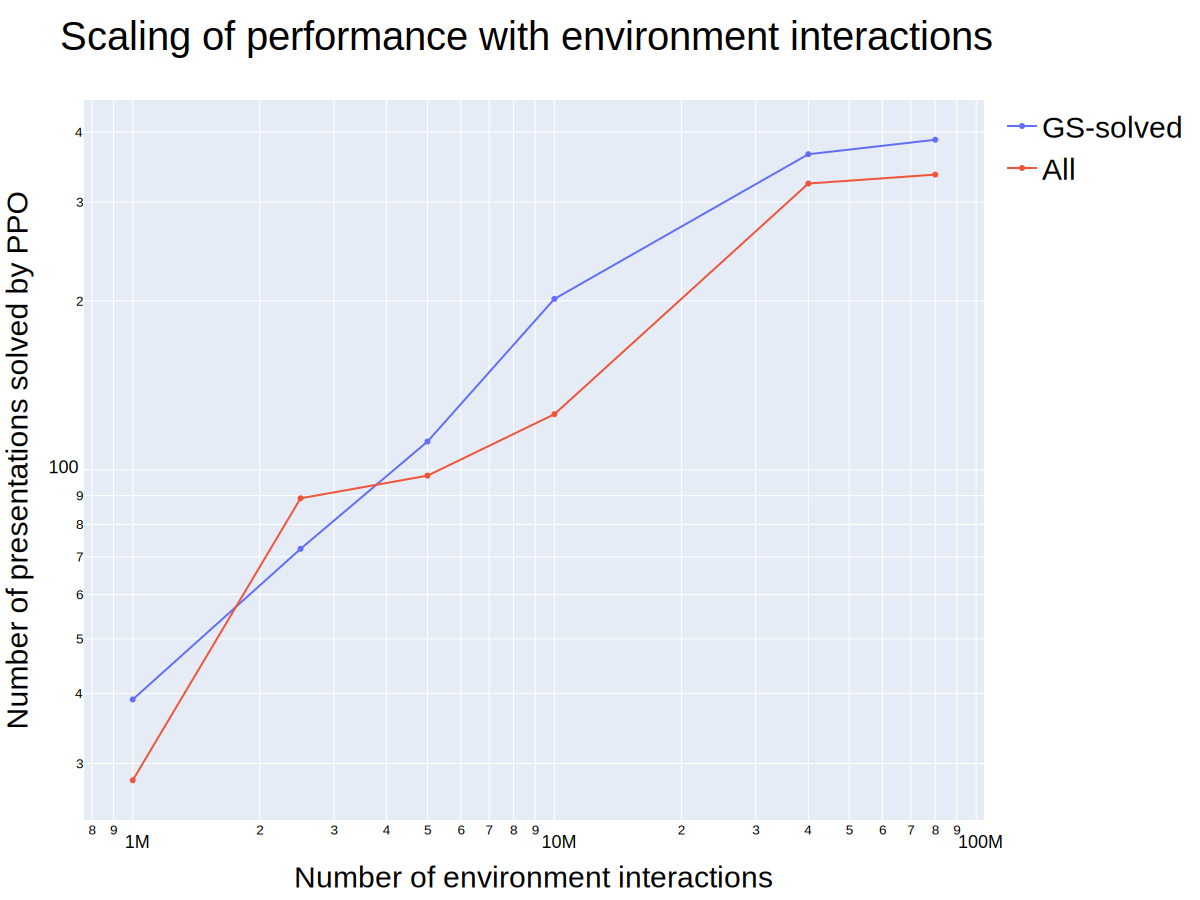

In [5]:
states_types = ("solved", "all")

data_perf_vs_E = {}
for state_type in states_types:
    initate_class = Performance_vs_Interactions(states_type=state_type)
    data_perf_vs_E[state_type] = initate_class.get_perf_vs_E()

#### ----------- #####

fig = go.Figure()

def get_legend(state_type):
    return "GS-solved" if state_type == "solved" else "All"

for state_type in states_types:
    x = data_perf_vs_E[state_type][0]
    y = data_perf_vs_E[state_type][1]
    fig.add_trace(go.Scatter(
            x=x, y=y, mode='markers+lines', name=f"{get_legend(state_type)}"
        ))
    
fig.update_layout(
            title='Scaling of performance with environment interactions',
            title_font=dict(size=40, family='Arial', color='black'),
            xaxis=dict(type='log', 
                       title='Number of environment interactions',
                       title_font=dict(size=30, family='Helvetica', color='black'),
                       tickfont=dict(size=18, family='Helvetica', color='black')),
            yaxis=dict(type='log', 
                       title='Number of presentations solved by PPO',
                       title_font=dict(size=30, family='Helvetica', color='black'),
                       tickfont=dict(size=18, family='Helvetica', color='black')),
            legend=dict(
            font=dict(size=30, family='Arial', color='black'),
            ),
            width=1200,
            height=900
        )
# Save to PDF
# fig.write_image("images/scaling_env.pdf")
fig.show()

### Horizon Length vs Interactions

In [20]:
class Horizon_vs_Interactions:
    """ 
    A class for analyzing the relationship between training horizon (timesteps) and interactions.

    Attributes:
    -----------
    states_type (str): The type of states used in the runs. This is a key parameter for filtering relevant runs.
    
    timesteps (float): The total number of environment interactions for each run. This must be either 4e7 or 1e7. 
        An assertion is made to ensure the correct value is used.
    
    Methods:
    --------
    relevant_runs():
        Retrieves the runs relevant to this experimental setup. Requires us to specify states_type and timesteps.
    
    _selection_criteria(run):
        Determines if a given run meets the criteria for inclusion based on its configuration and state.
    """

    def __init__(self, states_type, timesteps):
        self.states_type=states_type
        self.timesteps=timesteps
        assert self.timesteps in [4e7, 1e7], f"expect timesteps to be 4e7 or 1e7, found {timesteps}"
    
    @property
    def relevant_runs(self):
        """Get the runs that are relevant for this class. 
        Returns dict: 
        key: (total_timesteps, learning_rate)
        value: a list of 3 runs with different seeds
        """
        relevant_runs = {}
        total_relevant_runs = 0
        for run in runs:
            if self._selection_criteria(run):
                total_relevant_runs += 1
                max_env_steps = run.config["max_env_steps"]
                learning_rate = run.config["learning_rate"]

                if (max_env_steps, learning_rate) not in relevant_runs.keys():
                    relevant_runs[(max_env_steps, learning_rate)] = []

                relevant_runs[(max_env_steps, learning_rate)].append(run)

        print(f"{total_relevant_runs} runs found for the task!")
        return relevant_runs
    
    def _selection_criteria(self, run):
        cfg = run.config
        state = run.state
        allowed_states = ("finished") # could also be ("finished", "running")
        if all([cfg["num_steps"] == 512,
                cfg["states_type"] == self.states_type,
                cfg["anneal_lr"] == False,
                cfg["nodes_counts"] == [512, 512],
                cfg["total_timesteps"] == self.timesteps,
                state in allowed_states]):
            return True 
        else:
            return False


In [21]:
def get_timesteps_vs_performance(run_history, n_solved):
    """
    Finds the first timestep at which the performance in a run history meets or exceeds specified thresholds.

    Parameters:
    -----------
    run_history : A list or Numpy Array representing the performance metric recorded at each timestep during a run.
        
    n_solved : int or list of int
        The performance threshold(s) to check for. Can be a single integer or a list of integers. 
        The function will return the first timestep where each threshold is met or exceeded.

    Returns:
    --------
    dict
        A dictionary where the keys are the thresholds from `n_solved`, and the values are the corresponding
        timesteps at which each threshold was first met or exceeded.
    """

    if isinstance(n_solved, int):
        n_solved = [n_solved]    
    
    n_solved.sort()

    curr = 0
    out = {}

    for t, t_data in enumerate(run_history):
        if t_data >= n_solved[curr]:
            out[n_solved[curr]] = t
            curr += 1
            if curr == len(n_solved):
                break

    assert curr == len(n_solved), "curr has length less than n_solved"

    assert len(out) == len(n_solved)

    return out

In [25]:
def analyze_horizon_vs_interactions(state_types, n_solved, timesteps=4e7):
    """
    Analyzes the relationship between training horizon (timesteps) and interactions in a reinforcement learning setup.

    Parameters:
    -----------
    state_types (tuple or list of str): Types of states to analyze, e.g., ("solved", "all").
    n_solved (list of int): Performance thresholds at which we evaluate timesteps.
    timesteps (float, optional (default=4e7)): The total number of timesteps for the analysis. Must be either 4e7 or 1e7.

    Returns:
    --------
    new_outs (dict):
        A nested dictionary where the outer keys are state types, and the inner keys are performance thresholds (n_solved).
        The values are dictionaries that map horizons to the first timestep at which each performance threshold is met.
    """

    new_outs = {}  # Dictionary to store the results for each state type

    # Iterate over each state type
    for states_type in state_types:
        # Initialize the Horizon_vs_Interactions object for the current state type
        horizon_vs_interactions = Horizon_vs_Interactions(states_type=states_type, timesteps=timesteps)
        relevant_runs = horizon_vs_interactions.relevant_runs  # Get relevant runs based on selection criteria

        horizons = set()  # Set to collect unique horizons
        lrs = set()  # Set to collect unique learning rates

        # Collect all unique horizons and learning rates from relevant runs
        for (horizon, lr) in relevant_runs.keys():
            horizons.add(horizon)
            lrs.add(lr)

        optimal_lrs = {}  # Dictionary to store the optimal learning rate for each horizon
        for horizon in horizons:
            optimal_lrs[horizon] = 0  # Initialize the optimal learning rate for the current horizon
            prev_best_performance = -1  # Initialize the best performance tracker

            # Find the optimal learning rate for the current horizon
            for lr in lrs:
                curr_runs = relevant_runs[(horizon, lr)]
                assert len(curr_runs) == 3  # Ensure there are 3 runs for consistency
                mean_performance = np.mean([run.summary["charts/solved"] for run in curr_runs])  # Calculate mean performance
                if mean_performance > prev_best_performance:  # Update if current performance is better
                    prev_best_performance = mean_performance
                    optimal_lrs[horizon] = lr  # Set the optimal learning rate for this horizon

        # Get the best runs based on the optimal learning rates found
        best_runs = {(horizon, lr): relevant_runs[(horizon, lr)] for (horizon, lr) in optimal_lrs.items()}
        best_runs_mean_history = {(horizon, lr): [] for (horizon, lr) in best_runs.keys()}  # Initialize mean history storage

        # Calculate the mean performance history for each best run
        for (horizon, lr) in best_runs_mean_history:
            history = []
            for run in relevant_runs[(horizon, lr)]:
                run_history = [row["charts/solved"] for row in run.scan_history()]  # Get the solved performance history
                history.append(run_history)

            mean_history = np.array(history).mean(axis=0)  # Calculate mean history across runs

            best_runs_mean_history[(horizon, lr)] = mean_history  # Store the mean history

        outs = {}  # Dictionary to store the performance data for each horizon
        for (horizon, lr) in best_runs_mean_history:
            run_history = best_runs_mean_history[(horizon, lr)]
            n_solved_to_steps_dict = get_timesteps_vs_performance(run_history, n_solved)  # Map performance thresholds to timesteps
            outs[horizon] = n_solved_to_steps_dict  # Store the mapping for this horizon

        # Store the output in a nested dictionary format
        new_outs[states_type] = {}
        for (horizon, n_solved_to_steps_dict) in outs.items():
            for n_solved, steps in n_solved_to_steps_dict.items():
                if n_solved not in new_outs[states_type].keys():
                    new_outs[states_type][n_solved] = {}
                new_outs[states_type][n_solved][horizon] = steps  # Populate the final output dictionary

    return new_outs

In [26]:
state_types = ("solved", "all")  # Define the types of states to analyze
n_solved = [16, 32, 64, 96, 128, 160, 192, 224, 256]  
new_outs = analyze_horizon_vs_interactions(state_types, n_solved)

90 runs found for the task!
90 runs found for the task!


In [27]:
import plotly.graph_objects as go

# Create a scatter plot for each (k, v) pair in the dictionary using Plotly
fig = go.Figure()

marker_shapes = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'pentagon', 'hexagon']

for states_type in new_outs.keys():
    for idx, (k, v) in enumerate(new_outs[states_type].items()):
        if k < 300 and states_type == "all":
            x = list([h for h in v.keys() if h >= 32])
            x.sort()
            y = [v[kp] for kp in x]
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers', name=f'{k}',
                                    marker=dict(size=12, symbol=marker_shapes[idx % len(marker_shapes)])))

# Add legend and labels
fig.update_layout(
    title='Scaling of environment interactions with horizon length at fixed performance levels',
    title_font=dict(size=30, family='Arial', color='black'),
    xaxis=dict(#type='log', 
                title='Horizon Length',
                title_font=dict(size=30, family='Helvetica', color='black'),
                tickfont=dict(size=18, family='Helvetica', color='black')),
    yaxis=dict(#type='log', 
                title='Number of Environment Interactions',
                title_font=dict(size=30, family='Helvetica', color='black'),
                tickfont=dict(size=18, family='Helvetica', color='black')),
    legend=dict(
    font=dict(size=18, family='Arial', color='black'),
    ),
    legend_title='Presentations Solved',
    # template='plotly_white',
    width=1200,
    height=900
)

import os
if not os.path.exists("images"):
    os.mkdir("images")

# fig.write_image("images/env_vs_horizon.pdf")
fig.show()